## Instructions:
- You can use NN libraries such as tensorflow, pytorch, etc. But implement GAN and VAE on your own.
- Zero tolerance for plagiarism. Do not copy from Practice and Share; the student who submitted there originally only can use; Github tracks who pushed what code.
- Total marks: 50
- Marks will be for answering the questions asked below, not for the codes. Use plots, tables, etc. to convey your answers.

In [1]:
import CodingQuiz1lib as given
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import optimizers
import time
import scipy
tfd = tfp.distributions
np.random.seed(5)

# VAEs vs GANs
The objective of this exercise is to compare VAEs and GANs for a generative modeling task (generating samples from a mixture of Gaussians).

- Prepare the target probability distribution $p_x^*$ as a GMM with 5 components.
(Using snippets from CodingQuiz1.py is allowed)
- Construct and train a VAE to model $p^*_x$.
- Construct and train a GAN to model $p^*_x$.


## Questions
1. Plot the samples from original $p^*_x$, VAE and GANs to compare them visually. (You may plot them on same or different plots) [10 marks]
2. Quantify the performance of the two models and compare them. (Think what all metrics can you use - report as many as you can) [10 marks]
3. Expressivity vs Efficiency: Which of the two models is more expressive? Which is more efficient? (Number of parameters vs performance, computations vs performance, etc.) [10 marks]
4. Compare the pros and cons of the two models in a table. [10 marks]
5. Do you find a structure in the latent space in the two models? E.g., each Gaussian component of $p^*_x$ may correspond to a specific region in the latent space. [10 marks]

## Codes and Answers
It would be appreciated if you write modular codes and re-use them while answering different parts.

In [2]:
class Gaussian(given.Gaussian):
    def __init__(self, mu=None, sigma=None):
        given.Gaussian.__init__(self,mu,sigma)
        self.scale=np.linalg.cholesky(self.sigma)
        self.dist=tfd.MultivariateNormalTriL(loc=self.mu,scale_tril=self.scale)
    def tf_sample(self, S=1):
        return  tf.cast(self.dist.sample(S),"float64")
    def tf_log_prob(self,u):
        return tf.cast(self.dist.log_prob(u),"float32")
    def tf_prob(self,u):
        return self.dist.prob(u)
    def one_tf_prob(self,u):
        x=u-tf.transpose(self.mu)
        x1=tf.linalg.matvec(self.sigmainv,x)
        k=tf.tensordot(x1,x,1)
        return tf.math.exp(-0.5*k)/self.Z
    def my_tf_prob(self,u):  
        return tf.map_fn(lambda t:self.one_tf_prob(t),elems=tf.cast(u,"float64"))
    def my_tf_log_prob(self,u):
        return tf.math.log(self.my_tf_prob(u))

In [3]:
class GMM(given.GMM):
    def __init__(self):
        given.GMM.__init__(self)
        self.scale=list()
        self.mus=list()
        for i in self.components:
            self.scale.append(np.linalg.cholesky(i.sigma))
            self.mus.append(i.mu)
        self.dist=tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=self.weights),
                                        components_distribution=tfd.MultivariateNormalTriL(loc=self.mus,scale_tril=self.scale))
        self.my_components=list()
        for i in self.components:
            self.my_components.append(Gaussian(mu=i.mu,sigma=i.sigma))
        self.weights=tf.cast(self.weights,"float64")
    def sample(self, S=1):
        return  tf.cast(self.dist.sample(S),"float64")
    def tf_log_prob(self,u):
        return tf.cast(self.dist.log_prob(u),"float32")
    def tf_prob(self,u):
        return tf.cast(self.dist.prob(u),"float32")
    def one_tf_prob(self,u):
        p=0
        for z, w in enumerate(self.weights):
            p += w * self.my_components[z].one_tf_prob(u)
        return p
    def my_tf_prob(self,u):  
        return tf.map_fn(lambda t:self.one_tf_prob(t),elems=tf.cast(u,"float64"))
    def my_tf_log_prob(self,u):
        return tf.math.log(self.my_tf_prob(u))
    


In [4]:
# pr=[.2,.3,.5]
# u=[[10.0,5.0],[6.0,-5.0],[1.0,1.0]]
# var=[ [[1.0,0.0],[0.0,1.0]], [[2.0,0.0],[0.0,2.0]] ,[[1.5,0.0],[0.0,1.0]]]
# sd=[[1.0,1.0],[1.414,1.414],[1.5**.5,1]]
# base_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([2])) 
# mvgmm = tfd.MixtureSameFamily(
#     mixture_distribution=tfd.Categorical(probs=pr),
#     components_distribution=tfd.MultivariateNormalDiag(
#         loc=u,
#         scale_diag=sd)
# )
# nor1=tfd.MultivariateNormalDiag(loc=u[0],scale_diag=sd[0])
# nor2=tfd.MultivariateNormalDiag(loc=u[1],scale_diag=sd[1])
# nor3=tfd.MultivariateNormalDiag(loc=u[2],scale_diag=sd[2])
# arr=[nor1,nor2,nor3]
mvgmm=GMM()
pr=mvgmm.weights
arr=mvgmm.my_components


In [5]:
dataset_size = 1000000
data=tf.cast(mvgmm.sample(dataset_size),'float32')

In [6]:
nor=tfd.Normal(loc=0., scale=1.)

In [7]:
class Generator(keras.Model):
    
    def __init__(self, dim_input = 2):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = dim_input)
        self.layer1=layers.Dense(2, activation='relu')
        self.layer2=layers.Dense(2,activation='relu')
#         self.layer3=layers.Dense(16,activation='relu')
        self.layer4=layers.Dense(2)
        self.layer5=layers.Dense(2)
    def Sample(self,z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.reshape(nor.sample(batch*dim), shape=(batch, dim), name=None)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def call(self, input_tensor,params=True):
        x=self.input_layer(input_tensor)
        x=self.layer1(x)
        x=self.layer2(x)
#         x=self.layer3(x)
        z_mean=self.layer4(x)
        z_log_var=self.layer5(x)
        if params:
            return [z_mean,tf.exp(z_log_var)]
        return  self.Sample(z_mean,z_log_var)
    
    

In [8]:
gen=Generator()

In [9]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        self.input_layer = keras.layers.Dense(units = 2)
        self.layer1=layers.Dense(8, activation='relu')
        self.layer2=layers.Dense(8,activation='relu')
        self.layer3=layers.Dense(2)
        self.layer4=layers.Dense(2)
    def call(self, input_tensor,params=True):
        x = self.input_layer(input_tensor)
        x=self.layer1(x)
        x=self.layer2(x)
#         x=self.layer3(x)
#         return(x)
        z_mean=self.layer3(x)
        z_log_var=self.layer4(x)
        if params:
            return [z_mean,tf.exp(z_log_var)]
        return  self.Sample(z_mean,z_log_var)
    def Sample(self,z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.reshape(nor.sample(batch*dim), shape=(batch, dim), name=None)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
dis=Discriminator()

In [11]:
def cal_KL_divergence(means,diag):
    means_dot=tf.reduce_sum(tf.math.square(means),1)
    trace=tf.reduce_sum(diag,1)
    log_diag=tf.reduce_sum(tf.math.log(diag),1)
    result=0.5 * (trace-log_diag+means_dot-1)
    return result
def cal_one_of_Expected_value(X,mean,sigma2):
    log_trace=.5*tf.reduce_sum(tf.math.log(sigma2),1)
    val=.5*tf.reduce_sum(tf.divide(tf.square(X-mean),sigma2),1)
    return -(val+log_trace)
def calculate_reconstruction_loss(x,x_):
    return tf.math.sqrt(tf.reduce_sum(tf.square(x-x_),1))
def calculate_loss(gen,dis,X):
    zmeans,cov_diag=gen(X)
#     print("mean and varirence",zmeans,cov_diag)
    ## calculated KLD 
    KLD=cal_KL_divergence(zmeans,cov_diag)
    ### calculate E
    val=0
    for i in range(30):
        sample=gen(X,False) ## got value of Z
        xmean,x_diag=dis(sample) ## get u and sigma
#         sampleX=dis(sample,False)
        one_e=cal_one_of_Expected_value(X,xmean,x_diag)
        val=val+one_e
    val=val/30
#     sample=gen(X,False) ## got value of Z
#     x_=dis(sample,False)
    error=-KLD+val
#     print(val,KLD)
    return error

In [12]:
@tf.function()
def tde(data,generator,discriminator,optimizer):
  with tf.GradientTape() as tape:
    loss=-tf.reduce_mean(calculate_loss(generator,discriminator,data))
  gradients=tape.gradient(loss,tape.watched_variables())
  optimizer.apply_gradients(zip(gradients,tape.watched_variables()))
  return loss

In [13]:
vae_begin=time.time()
epochs = 1
optimizer = optimizers.Adam(learning_rate = 0.001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
    for j in range(batches_per_epoch):
        data_batch = data[batch_size*j:batch_size*(j+1)]
#       print("batch",data_batch)
        last_loss = tde(data_batch, gen, dis, optimizer)
    print(last_loss)
vae_end=time.time()

tf.Tensor(0.706988, shape=(), dtype=float32)


In [14]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [16]:
class GAN_Generator(keras.Model):
    
    def __init__(self, random_noise_size = 2):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.layer1=layers.Dense(16, activation='relu')
        self.layer2=layers.Dense(16,activation='relu')
        self.layer3=layers.Dense(2)

        
    def call(self, input_tensor):
        x=self.input_layer(input_tensor)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return  x
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

In [17]:
def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

In [18]:
generator = GAN_Generator()

In [19]:
fake = generator(np.random.uniform(-1,1, size =(1,2)))
print(fake)

tf.Tensor([[-0.34288642 -0.33658183]], shape=(1, 2), dtype=float32)


In [20]:
class GAN_Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        self.input_layer = keras.layers.Dense(units = 2)
        self.layer1=layers.Dense(16, activation='relu')
#         self.layer2=layers.Dense(16,activation='relu')
        self.layer3=layers.Dense(1)

        
        self.logits = keras.layers.Dense(units = 1)  # This neuron tells us if the input is fake or real
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x=self.layer1(x)
#         x=self.layer2(x)
        x=self.layer3(x)

        return x

In [21]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    
    total_loss = tf.add(real_loss , fake_loss)
    
    return total_loss

In [22]:
discriminator = GAN_Discriminator()

In [23]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

In [24]:
@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 2)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 

In [25]:
gan_begin=time.time()
n=2
epochs = 2
batch_size = 100
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
    for j in range(batches_per_epoch):
        data_batch = data[batch_size*j:batch_size*(j+1)]
        training_step(generator, discriminator, data_batch ,batch_size = batch_size , k = 1)
gan_end=time.time()

## 1) Comparison of plotting

### GMM distribution

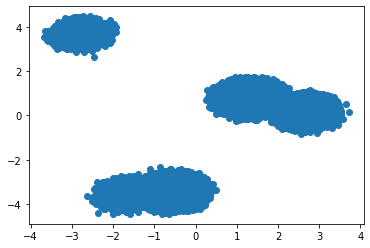

In [26]:
plt.scatter(data[:,0],data[:,1])

### Distribution from VAE 

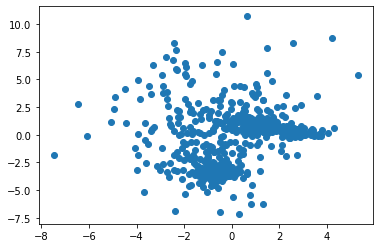

In [27]:
data_p=tf.reshape(nor.sample(1000*2),(1000,2))
X=dis(data_p,False)
plt.scatter(X[:,0],X[:,1])

### Distribution from GAN

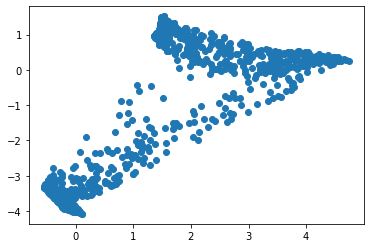

In [28]:
x=list()
y=list()
for i in range(2000):
    temp=np.random.uniform(-1,1, size = (1, 2))
    x.append(generator(temp)[0])
    y.append(temp[0])
x=np.array(x)
plt.scatter(x[:,0],x[:,1])

### 5) Latent space exploration

In [29]:
def class_classification(x):
    p=list()
    for i in range(len(arr)):
        p.append(arr[i].tf_prob(x)*pr[i])
    tag=p.index(max(p)) 
    return tag

### For GANS

In [30]:
sepa=[[],[],[],[],[]]
print(arr)
for i in range(len(x)):
    n=int(class_classification(tf.cast(x[i],'float64')))
    sepa[n].append(y[i])

[<__main__.Gaussian object at 0x00000279DE2EBBE0>, <__main__.Gaussian object at 0x00000279803F1FD0>, <__main__.Gaussian object at 0x0000027981110520>, <__main__.Gaussian object at 0x000002798111FE80>, <__main__.Gaussian object at 0x00000279DE300FA0>]


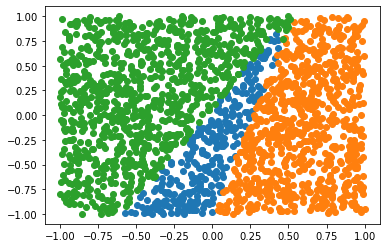

In [39]:

for i in range(len(arr)):
    arr1=np.array(sepa[i])
    if(len(arr1)>0):
        plt.scatter(arr1[:,0],arr1[:,1])
plt.show()

### For VAE

In [32]:
sepa1=[[],[],[],[],[]]
for i in range(len(arr)):
    samples=arr[i].sample(700)
    sepa1[i]=dis(samples,False)
 

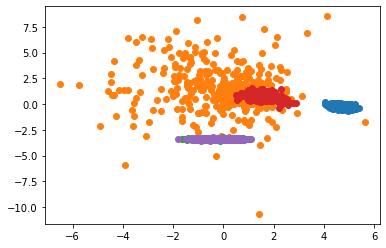

In [33]:
for i in range(len(arr)):
    arr1=np.array(sepa1[i])
    plt.scatter(arr1[:,0],arr1[:,1])
plt.show()

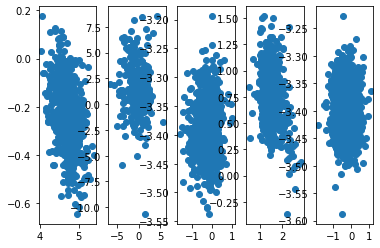

In [34]:
for i in range(len(arr)):
    arr1=np.array(sepa1[i])
    plt.subplot(1, 5, i+1)
    plt.scatter(arr1[:,0],arr1[:,1])
plt.show()

## 2) Metric for comparison

### Using FID 
- FID(x,g)=$|u_x-u_g|^2+tr(cov_x+cov_g-2(cov_xcov_g)^{1/2})$

In [35]:
def cal_FID(x,g):
    mean_x=np.mean(x,0)
    mean_g=np.mean(g,0)
    cov_x=np.cov(np.transpose(x))
    cov_g=np.cov(np.transpose(g))
    dif=np.sum(np.square(mean_x-mean_g))
    fid=dif+np.trace(cov_x+cov_g-2*scipy.linalg.fractional_matrix_power(np.matmul(cov_x,cov_g),.5))
    return fid


### For VAE

In [36]:
print(cal_FID(data[:10000,:],X))

0.9454447817718279


### For GANS

In [37]:
print(cal_FID(data[:10000,:],x))

0.3642655807410722


## 3) Expressivity Vs Effiency 
<table style="width:90%">
    <tr>
        <th>Property</th>
    <th>GAN</th>
    <th>VAE</th>
    </tr>
    <tr>
      <td>traning speed</td>
    <td>Fast</td>
    <td>Slow</td>
    </tr>
    <tr>
    <td> number of parameters</td>
    <td>Less</td>
    <td>More</td>
    </tr>
    <tr>
    <td> Exact Density</td>
    <td>NO</td>
    <td>YES</td>
    </tr>
    </table>
    
    
 


#####  Expressive:-
 VAE are more expressive and they deal with probality distribution unlike GAN (more over a better visulization of latent space)
#####  Effecient:-
 Usually Gans are said to be more efficient 

## 4) Comparison

#### GANS
<table style="width:90%">
    <tr>
    <th>PROS</th>
    <th>CONS</th>
    </tr>
    <tr>
        <td>Easy generation of similar looking Data.</td>
        <td>Non-convergence: the model parameters oscillate, destabilize and never converge.</td>
    </tr>
    <tr>
        <td>GANs are unsupervised, so no labelled data is required to train them.</td>
        <td>Mode collapse: the generator collapses which produces limited varieties of samples.Unlike VAE</td>
    </tr>
    <tr>
        <td>GAN generate the sharpest images unlike VAE</td>
        <td>Diminished gradient: the discriminator gets too successful that the generator gradient vanishes and learns nothing.</td>
    </tr>
    <tr>
        <td></td>
        <td>Not easy to visualize latent space </td>
    </tr>
</table>

####  VAE
<table style="width:90%">
<tr>
<th>PROS</th>
<th>CONS</th>
</tr>
<tr>
<td>Gives the probality distribution advantage over GAN</td>
<td>Not as good at generation compared to GAN</td>
</tr>
<tr>
<td>The ability to set complex priors in the latent is also nice especially in cases where you know something should make sense or you have a desired latent distribution.</td>
<td>Slower to train compared to GAN</td>
</tr>
    <tr>
<td>Easy and direct mapping to latent space.</td>

</tr>

</table>

In [38]:
print("Time required to train GAN ",-1*(gan_begin-gan_end))
print("Time required to train VAE ",-1*(vae_begin-vae_end))

Time required to train GAN  15.75978708267212
Time required to train VAE  27.951810836791992
